In [ ]:
import os
import string
from dotenv import load_dotenv
import torch
import math
from PIL import Image
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

from huggingface_hub import login

load_dotenv()
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
login(token=HUGGINGFACE_API_KEY)

/home/anhndt/.conda/envs/draw-with-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)
letters = string.ascii_uppercase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "google/paligemma2-10b-mix-448"
processor = AutoProcessor.from_pretrained(model_path, use_fast=True)
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_path,
    low_cpu_mem_usage=True,
    quantization_config=quantization_config,
).to(device)

Loading checkpoint shards: 100%|██████████| 4/4 [00:43<00:00, 10.81s/it]


In [4]:
import torch
import matplotlib.pyplot as plt

def ocr(image, free_chars=4, use_num_char=False, return_text=False):
    inputs = (
        processor(
            text="<image>ocr\n",
            images=image,
            return_tensors="pt",
        )
        .to(torch.float16)
        .to(model.device)
    )
    input_len = inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=32, do_sample=False)
        outputs = outputs[0][input_len:]
        decoded = processor.decode(outputs, skip_special_tokens=True)

    num_char = len(decoded)
    confidence = min(1.0, math.exp(-num_char + free_chars))

    if return_text:
        if use_num_char:
            return (confidence, num_char, decoded)
        else:
            return (confidence, decoded)
    else:
        if use_num_char:
            return (confidence, num_char)
        else:
            return confidence

def visualize_ocr(image, text):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"OCR Result: {text}", fontsize=12, pad=20)
    plt.show()

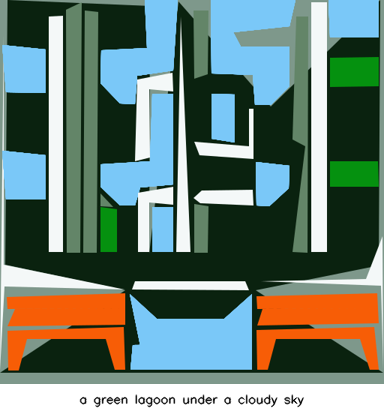

In [3]:
image_path = r"/home/anhndt/draw-with-llm/data/results/Version11-Minimal_flat_icon_no_details-512x512-have_image_compression/61b500/submit - 0 - 0.4407.png"
image = Image.open(image_path)
image

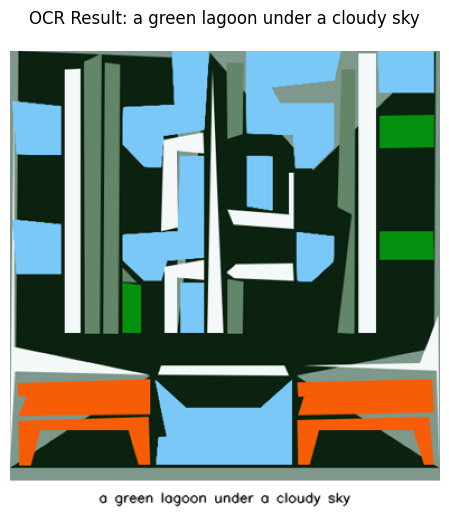

In [5]:
# Đọc ảnh
image = Image.open(image_path)

# Gọi OCR và lấy văn bản
confidence, text = ocr(image, return_text=True)

# Hiển thị kết quả
visualize_ocr(image, text)